In [1]:
%matplotlib inline

# Imports

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from time import time
from copy import copy

# ELMAG related imports

In [3]:
from elmagpy202.elmag import Elmag
from elmagpy202 import halo
from elmagpy202 import binbybin as bbb

# Initialization and Configuration

In [4]:
config = {
    "model":          6, # EBL model, model 6 = Dominguez et al. (2011) model
    "ethr":           1e+8, # Energy threshold in eV below which the cascade energy losses are integrated out
    "egmax":          10e+12, # Maximum energy in eV for the injected gamma rays
    "ir_rescale":     1.00, # Rescaling of the EBL photon density
    "cohlnth":        1.00, # Coherence length of the IGMF in Mpc
    "th_jet":       1.00, # Jet opening angle in degrees
    "igmf":           1e-12, # IGMF strength in G. Note that at the moment it's not changing with z
    "emin":           1.e+8, # Minimum energy in eV of the injected photons
    "ebreak":         1.e+13, # Break energy in eV in case you want to model a broken power law (BPL)
    "gam1":           -2, # Spectral index below Ebreak as in dN / dE ~ E^gam1
    "gam2":           -2, # Spectral index above Ebreak as in dN / dE ~ E^gam2
    "iseed":           0, # Seed for the random number generation, must be an integer
    "tabledir":	      "Tables/" #path to the EBL tables provided within Elmag
    }

In [5]:
e = Elmag(**config)

In [6]:
e.igmf = 1e-15
e.gam1 = config['gam1']
e.gam1 = config['gam2']
e.ebreak = 31.6227e12
e.egmax = 31.6227e12
e.emin = 1e8
e.n_bine = int(np.log10(e.egmax / e.emin) * 8 + 2) # Set to 8 bins per decade, with left bin boundary aligned with 1 GeV
e.set_params()

# Run ELMAG 

Run bin by bin calculation twice for two different indices

In [7]:
z = 0.14 # source redshift 
nmax = 1e2 # number of injected particles for weight = 1
 # results for injected photons


t0 = time()
for ig,gam in enumerate([-2.,-1.6]):
    e.gam1 = gam
    e.set_params()
    binByBinCasc = np.ones((e.EeV.shape[0],     # true energy axis
                        e.EeV.shape[0],     # obs energy axis
                        e.n_binth,  # angular separation axis
                        e.n_bint,   # time delay axis
                        )) * e.replaceZero
    binByBinInit = np.ones(e.EeV.shape[0]) * e.replaceZero
    for i,E in enumerate(e.EeV): # run the cascade for each energy bin
        e.set_result_arrays()
        e.bin_by_bin_cascade(z,nmax, ibin = i, ebl_weight=4)
        binByBinCasc[i] = e.hist_etht
        binByBinInit[i] = e.init_hist.sum()
        
    if not ig:
        fbbbCasc = copy(binByBinCasc)
        fbbbInit = copy(binByBinInit)
print 'it took ',time() - t0, 's'

it took  183.207966089 s


Calculate the new weights. Works only if the ELMAG weighting is disabled, i.e. all particles are traced by setting $\alpha_\mathrm{smp} = 0$ and if we are dealing with simple power laws as injection spectra. In this case, the new weights are simple calculated through
$$w' = \left(\frac{E_0}{E_\mathrm{max}} \right)^{\alpha' - \alpha},$$
where the old power law is given by $dN / dE \propto E^\alpha$ and the new injection spectrum by $dN/dE \propto E^{\alpha'}$. $E_0$ is the central bin energy. 

Here, $\alpha = -2$ and $\alpha' = -1.6$. The output of the reweighting funtion has the dimension of the true energy axis and needs to be multiplied with this axis.

In [9]:
w = bbb.calc_spectral_weights(e.EeV, e.ebreak, -2., -1.6)

Apply the weights, need to be applied to true energy (0) axis:

In [12]:
print fbbbCasc.shape
print w.shape
fbbbCascWeighted = np.swapaxes(np.swapaxes(copy(fbbbCasc),0,-1) * w, 0, -1)
print fbbbCascWeighted.shape

(44, 44, 93, 48)
(44,)
(44, 44, 93, 48)


Apply a time cut:

In [15]:
tmax = 1e6
bbbTcut = bbb.apply_time_cut(binByBinCasc, e.t_lbounds,tmax)
fbbbTcut = bbb.apply_time_cut(fbbbCasc, e.t_lbounds,tmax)
fbbbCascWeightedTcut = bbb.apply_time_cut(fbbbCascWeighted, e.t_lbounds, tmax)

Plot the spectra:

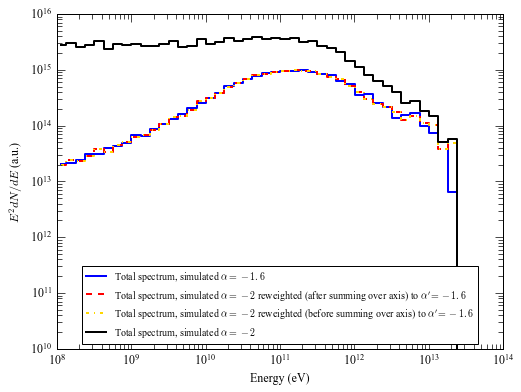

In [30]:
plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
cp = plt.cm.plasma

plt.plot(e.EeV , 
#         binByBinCasc.sum(axis = 3).sum(axis = 2).sum(axis = 0) * e.EeV,
         bbbTcut.sum(axis = 2).sum(axis = 0) * e.EeV,
         color = 'b',
         drawstyle = 'steps-mid', lw = 2, ls = '-',
        label = r'Total spectrum, simulated $\alpha = -1.6$ ')

# reweighted output that is stored in fits file:
plt.plot(e.EeV , 
#         (fbbbCasc.sum(axis = 3).sum(axis = 2).T * w).T.sum(axis = 0) * e.EeV, 
         (fbbbTcut.sum(axis = 2).T * w).T.sum(axis = 0) * e.EeV, 
         color = 'r',
         drawstyle = 'steps-mid', lw = 2, ls = '--',
        label = r"Total spectrum, simulated $\alpha = -2$ reweighted (after summing over axis) to $\alpha' = -1.6$")
# reweighted raw simulation output:
plt.plot(e.EeV , 
         fbbbCascWeightedTcut.sum(axis = 2).sum(axis = 0) * e.EeV, 
         color = 'gold',
         drawstyle = 'steps-mid', lw = 2, ls = '-.',
        label = r"Total spectrum, simulated $\alpha = -2$ reweighted (before summing over axis) to $\alpha' = -1.6$")
plt.plot(e.EeV , 
         fbbbTcut.sum(axis = 2).sum(axis = 0) * e.EeV, 
         color = '0.',
         drawstyle = 'steps-mid', lw = 2, ls = '-',
        label = r'Total spectrum, simulated $\alpha = -2$ ')

plt.legend(loc = 'lower center', fontsize = 'medium')
v = np.array(plt.axis())
v[-2] = v[-1] / 1e6
plt.axis(v)
plt.xlabel('Energy (eV)')
plt.ylabel('$E^2 dN / dE$ (a.u.)')

Test the 68% containment radius calculation

In [32]:
r = []
r.append( bbb.calc_cont_radius_2d(bbbTcut,e.EeV_lbounds,e.th,conf = 0.68, interp = True)) # the -1.6 sim
r.append( bbb.calc_cont_radius_2d(fbbbTcut,e.EeV_lbounds,e.th,conf = 0.68, interp = True)) # the -2 sim 
r.append( bbb.calc_cont_radius_2d(fbbbCascWeightedTcut,e.EeV_lbounds,e.th,conf = 0.68, interp = True)) # the reweighted -1.6 sim

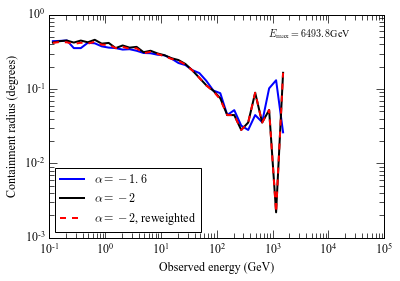

In [55]:
label = [r'$\alpha = -1.6$',r'$\alpha = -2$',r'$\alpha = -2$, reweighted']
ls = ['-','-','--']
color = ['b','0.','r']
ide = -6
for i,rr in enumerate(r):
    plt.loglog(e.EeV / 1e9,rr[ide], label = label[i], lw = 2, ls = ls[i], color = color[i])

plt.annotate('$E_\mathrm{{max}} = {0:.1f}$GeV'.format(e.EeV[ide]/1e9), xy = (0.9,0.9), 
            xycoords = 'axes fraction', ha = 'right')
plt.xlabel('Observed energy (GeV)')
plt.ylabel('Containment radius (degrees)')
plt.legend(loc = 3)

$\bf{Conclusion}$: Re-weighting works for spectrum, containment radius is unaffected by different spectral indices, as long as maximum energy is sufficiently large (i.e. enough cascade photons).